# STFT

$$
X[m;k] = \sum_{n=0}^{L-1}x[m+n]e^{-j2{\pi}nk/L}
$$

__STFT Parameters__
* $m :=$ which sample the current stft window is starting on. $m \in [0,N-m]$
    * $\Delta m := $ how much $m$ is shifted each time
* $L :=$ window size
    * Higher $L$ gives more frequency resolution, less time resolution. Better for recognizing vowels.
    * Lower $L$ gives more time resolution, less frequency resolution. Better for recognizing consonants.
* $k :=$ frequency index. $k \in [0, L]$
* _Convolution_ i.e. how the discrete time sample $x$ is weighted before being DFT'd

In [2]:
from IPython.display import Audio
import numpy as np
import matplotlib.pyplot as plt
import warnings
# warnings.filterwarnings("ignore", category=RuntimeWarning) 

# freq_spec = np.arange(L) * fs/L

def gen_signal(f, fs, t, pad=0.):
    """
    generates a sample of length [t] seconds sampled at [fs]hz with frequency [f]
    pad with [pad] seconds of silence
    """
    dt = 1. / fs  # time between samples
    N = fs * t  # no. samples
    n = np.arange(N)  # sample indexes
    n_t = n * dt  # time indexes
    silence = np.zeros(int(fs*pad))
    return np.concatenate([silence, np.sin(2. * np.pi * f * n_t), silence])

def gen_forward_matrix(N):
    """ matrix for DFT """
#     ns = np.arange(N)
#     ks = np.array([ns]).T
#     return np.exp(-1j * 2 * np.pi * ks * ns / N)
    ns = np.arange(N)
    ks = np.array([ns]).T
    return np.exp(-1j * 2 * np.pi * ks * ns / N)
    

def gen_inverse_matrix(N):
    return gen_forward_matrix(N).conjugate().T

def dft(x, M=None):
    if M is None:
        M = gen_forward_matrix(len(x))
    return np.dot(M, x)

def inv_dft(x, M=None):
    if M is None:
        M = gen_inverse_matrix(len(x))
    return np.dot(M, x)
    


    

In [3]:
fs = 44_100

test_signal = np.concatenate([gen_signal(f, fs, 1, pad=.2) for f in (1000, 5000, 10000)  ])

In [4]:
Audio(test_signal, rate=fs)

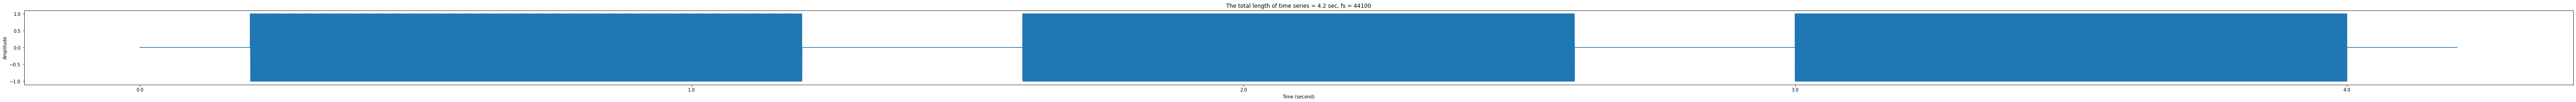

In [9]:
total_ts_sec = len(test_signal)/fs
tt = np.arange(len(test_signal))
plt.figure(figsize=(100,3))
plt.plot(test_signal)
plt.xticks(np.arange(0,len(test_signal),fs),
           np.arange(0,len(test_signal)/fs,1))
plt.ylabel("Amplitude")
plt.xlabel("Time (second)")
plt.title("The total length of time series = {} sec, fs = {}".format(len(test_signal)/fs, fs))
plt.show()

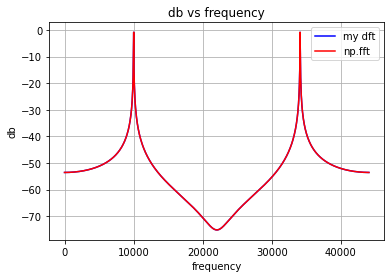

In [10]:
# this is to sanity check my dft implementation works
tmp = gen_signal(10000, fs, 1)
N = 1000
freq_spec = np.arange(N)*fs/N
# my_dft = 2/N * np.abs(dft(test_signal[:N]))
# my_dft = 20. * np.where(my_dft>0., np.log10(my_dft), 0)

my_dft = 20. * np.log10(2/N * np.abs( dft(tmp[:N]) ) )
np_fft = 20. * np.log10(2/N * np.abs( np.fft.fft(tmp[:N]) ) )

plt.plot(freq_spec, my_dft, color = "blue", label = "my dft")
plt.plot(freq_spec, np_fft, color = "red", label = "np.fft")
plt.grid()
plt.legend(loc = 'upper right')
plt.title("db vs frequency")
plt.xlabel("frequency")
plt.ylabel("db")
plt.show()


In [11]:
# implement hanning window fn
def apply_hanning(x):
    N = len(x)
    w = [0.5*(1+np.cos((2*np.pi*n)/N)) for n in range(0,N)]
    return x * w

<ipython-input-12-f0b13fab06cf>:27: RuntimeWarning: divide by zero encountered in log10
  stft_db = 20*np.log10(np.abs(stft[:L//2, :])*2)


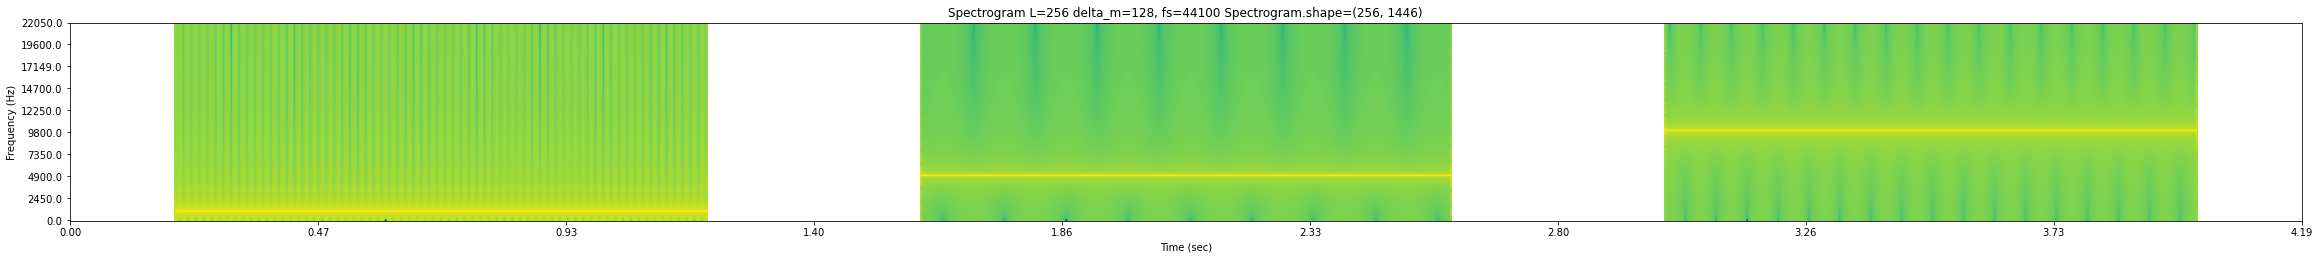

In [12]:
def get_stft(signal, L, delta_m, conv=None):
    """
    :param signal: time-sampled signal
    :param L: window size per DFT in samples
    :param delta_m: how many samples the window is moved 
    :param conv: convolution function for signal
    """
    N = len(signal)
    M = gen_forward_matrix(L)
    ms = np.arange(0, N-L, delta_m)
    dfts = None
    for m in ms:
        window = signal[m:m+L]
        if conv:
            window = conv(window)
        freq_window = np.array([dft(window, M=M)]).T
        dfts = freq_window if dfts is None else np.hstack([
            dfts, 
            freq_window
        ])
    return ms, dfts

def plot_spectrogram(ms, stft, fs):    
    plt.figure(figsize=[40,40])
    L = stft.shape[0]
    # we only look at DFT freq up to nyquist limit fs/2, and normalize out imag components
    stft_db = 20*np.log10(np.abs(stft[:L//2, :])*2)
    plt_spec = plt.imshow(
        stft_db,
        origin='lower'
    )
    
    ## create ylim
    num_yticks = 10
    ks = np.linspace(0, L/2, num_yticks)
    ks_hz = ks * fs // (L)
    plt.yticks(ks,ks_hz)
    plt.ylabel("Frequency (Hz)")

    ## create xlim
    num_xticks = 10
    ts_spec = np.linspace(0, len(ms), num_xticks)
    ts_spec_sec  = ["{:4.2f}".format(i) for i in np.linspace(0, ms[-1]/fs, num_xticks)]
    plt.xticks(ts_spec,ts_spec_sec)
    plt.xlabel("Time (sec)")

    plt.title(f"Spectrogram L={L} delta_m={delta_m}, fs={fs} Spectrogram.shape={stft.shape}")
#     plt.colorbar(None, use_gridspec=True)
    plt.show()
    return(plt_spec)

L = 256
delta_m = 128
ms, stft = get_stft(test_signal[:], L, delta_m)
plot_spectrogram(ms, stft, fs)

<ipython-input-12-f0b13fab06cf>:27: RuntimeWarning: divide by zero encountered in log10
  stft_db = 20*np.log10(np.abs(stft[:L//2, :])*2)


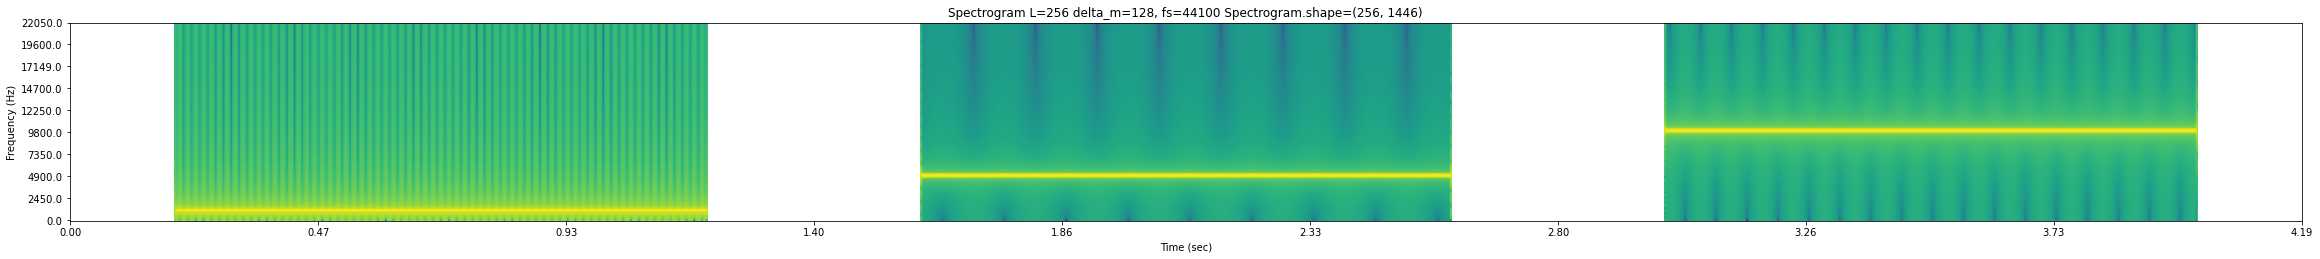

In [13]:
ms, stft = get_stft(test_signal[:], L, delta_m, conv=apply_hanning)
plot_spectrogram(ms, stft, fs)

In [14]:
# reconstruct original signal from stft
def get_istft(stft, delta_m):
    L = stft.shape[0]
    M = gen_inverse_matrix(L)
    signal = np.array([])
    m = delta_m
    for col in range(stft.shape[1]):
        signal_window = inv_dft(stft[:, col], M=M)
        signal = np.concatenate([
            signal[:m],
            signal_window
        ])
        m += delta_m
    return signal * (1/L)


orig_signal = np.concatenate([gen_signal(f, fs, 1, pad=.2) for f in (200, 400, 600)  ])
ms, stft = get_stft(orig_signal, L, delta_m)
reconstructed_signal = get_istft(stft, delta_m)
print(orig_signal.shape)
print(reconstructed_signal.shape)
    
    
    

(185220,)
(185344,)


In [15]:
Audio(orig_signal, rate=fs)

In [16]:
Audio(reconstructed_signal, rate=fs)

/Users/samsilverstein/opt/anaconda3/lib/python3.8/site-packages/IPython/lib/display.py:157: ComplexWarning: Casting complex values to real discards the imaginary part
  data = np.array(data, dtype=float)
